In [1]:
#!pip install small-text
#!pip install datasets
#!pip install sentence-transformers
#!pip install setfit
#!pip install seaborn


In [4]:
import datasets
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

In [5]:
dataset = datasets.load_dataset('financial_phrasebank', 'sentences_allagree')

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

In [6]:
df = pd.DataFrame(dataset['train'])

In [7]:
import numpy as np
from small_text import TextDataset

In [8]:
target_labels = np.arange(3)

In [9]:
df

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,"For the last quarter of 2010 , Componenta 's n...",2
2,"In the third quarter of 2010 , net sales incre...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2
...,...,...
2259,Operating result for the 12-month period decre...,0
2260,HELSINKI Thomson Financial - Shares in Cargote...,0
2261,LONDON MarketWatch -- Share prices ended lower...,0
2262,Operating profit fell to EUR 35.4 mn from EUR ...,0


In [10]:
df.iloc[499]

sentence    Headquartered in this city , the company is ne...
label                                                       1
Name: 499, dtype: object

In [11]:
train = TextDataset.from_arrays(dataset['train']['sentence'][:500], np.array(dataset['train']['label'][:500]), target_labels=target_labels)
test = TextDataset.from_arrays(dataset['train']['sentence'][499:1300], np.array(dataset['train']['label'][499:1300]), target_labels=target_labels)


/usr/local/lib/python3.10/dist-packages/small_text/utils/annotations.py:67: ExperimentalWarning: The function from_arrays is experimental and maybe subject to change soon.
  warnings.warn(f'The {subject} {func_or_class.__name__} is experimental '


# Active Learning

In [12]:
from small_text.integrations.transformers.classifiers.setfit import SetFitModelArguments
from small_text.integrations.transformers.classifiers.factories import SetFitClassificationFactory

sentence_transformer_model_name = 'sentence-transformers/paraphrase-mpnet-base-v2'
setfit_model_args = SetFitModelArguments(sentence_transformer_model_name)
clf_factory = SetFitClassificationFactory(setfit_model_args, num_classes=3)

In [13]:
from small_text import (
    PoolBasedActiveLearner,
    random_initialization_balanced,
    BreakingTies,
    SubsamplingQueryStrategy
)

In [14]:
query_strategy = SubsamplingQueryStrategy(BreakingTies())
setfit_train_kwargs = {'show_progress_bar': False}
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train, fit_kwargs={'setfit_train_kwargs': setfit_train_kwargs})

In [15]:
# simulate a warm start
def initialize_active_learner(active_learner, y_train):

    x_indices_initial = random_initialization_balanced(y_train, n_samples=10)
    y_initial = y_train[x_indices_initial]

    active_learner.initialize_data(x_indices_initial, y_initial)

    return x_indices_initial


initial_indices = initialize_active_learner(active_learner, train.y)
labeled_indices = initial_indices

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.70k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 400
  Num epochs = 1
  Total optimization steps = 13
  Total train batch size = 32


In [16]:
import gc
import torch
from sklearn.metrics import accuracy_score


num_queries = 14

y_pred = []


def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)

    test_acc = accuracy_score(y_pred_test, test.y)

    precision, recall, f1, _ = precision_recall_fscore_support(y_pred_test, test.y, average='macro',zero_division=1)

    print('Train accuracy: {:.2f}'.format(accuracy_score(y_pred, train.y)))
    print('Test accuracy: {:.2f}'.format(test_acc))

    return test_acc, y_pred_test, precision, recall


accuracy_list = []
precision_list = []
recall_list = []
label_list = []


for i in range(num_queries):
    q_indices = active_learner.query(num_samples=10)

    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[q_indices]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)

    # memory fix: https://github.com/UKPLab/sentence-transformers/issues/1793
    gc.collect()
    torch.cuda.empty_cache()

    labeled_indices = np.concatenate([q_indices, labeled_indices])

    print('---------------')
    print('Iteration #{:d} ({} samples)'.format(i, len(labeled_indices)))
    label_list.append(len(labeled_indices))

    test_acc, y_pred_test, precision, recall = evaluate(active_learner, train[labeled_indices], test)
    accuracy_list.append(test_acc)
    precision_list.append(precision)
    recall_list.append(recall)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 800
  Num epochs = 1
  Total optimization steps = 25
  Total train batch size = 32


---------------
Iteration #0 (20 samples)
Train accuracy: 1.00
Test accuracy: 0.64


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1200
  Num epochs = 1
  Total optimization steps = 38
  Total train batch size = 32


---------------
Iteration #1 (30 samples)
Train accuracy: 1.00
Test accuracy: 0.87


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1600
  Num epochs = 1
  Total optimization steps = 50
  Total train batch size = 32


---------------
Iteration #2 (40 samples)
Train accuracy: 1.00
Test accuracy: 0.86


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 2000
  Num epochs = 1
  Total optimization steps = 63
  Total train batch size = 32


---------------
Iteration #3 (50 samples)
Train accuracy: 1.00
Test accuracy: 0.92


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 2400
  Num epochs = 1
  Total optimization steps = 75
  Total train batch size = 32


---------------
Iteration #4 (60 samples)
Train accuracy: 1.00
Test accuracy: 0.92


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 2800
  Num epochs = 1
  Total optimization steps = 88
  Total train batch size = 32


---------------
Iteration #5 (70 samples)
Train accuracy: 1.00
Test accuracy: 0.94


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 3200
  Num epochs = 1
  Total optimization steps = 100
  Total train batch size = 32


---------------
Iteration #6 (80 samples)
Train accuracy: 1.00
Test accuracy: 0.95


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 3600
  Num epochs = 1
  Total optimization steps = 113
  Total train batch size = 32


---------------
Iteration #7 (90 samples)
Train accuracy: 1.00
Test accuracy: 0.93


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 4000
  Num epochs = 1
  Total optimization steps = 125
  Total train batch size = 32


---------------
Iteration #8 (100 samples)
Train accuracy: 1.00
Test accuracy: 0.94


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 4400
  Num epochs = 1
  Total optimization steps = 138
  Total train batch size = 32


---------------
Iteration #9 (110 samples)
Train accuracy: 1.00
Test accuracy: 0.95


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 4800
  Num epochs = 1
  Total optimization steps = 150
  Total train batch size = 32


---------------
Iteration #10 (120 samples)
Train accuracy: 1.00
Test accuracy: 0.93


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 5200
  Num epochs = 1
  Total optimization steps = 163
  Total train batch size = 32


---------------
Iteration #11 (130 samples)
Train accuracy: 1.00
Test accuracy: 0.93


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 5600
  Num epochs = 1
  Total optimization steps = 175
  Total train batch size = 32


---------------
Iteration #12 (140 samples)
Train accuracy: 1.00
Test accuracy: 0.92


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 6000
  Num epochs = 1
  Total optimization steps = 188
  Total train batch size = 32


---------------
Iteration #13 (150 samples)
Train accuracy: 1.00
Test accuracy: 0.92


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

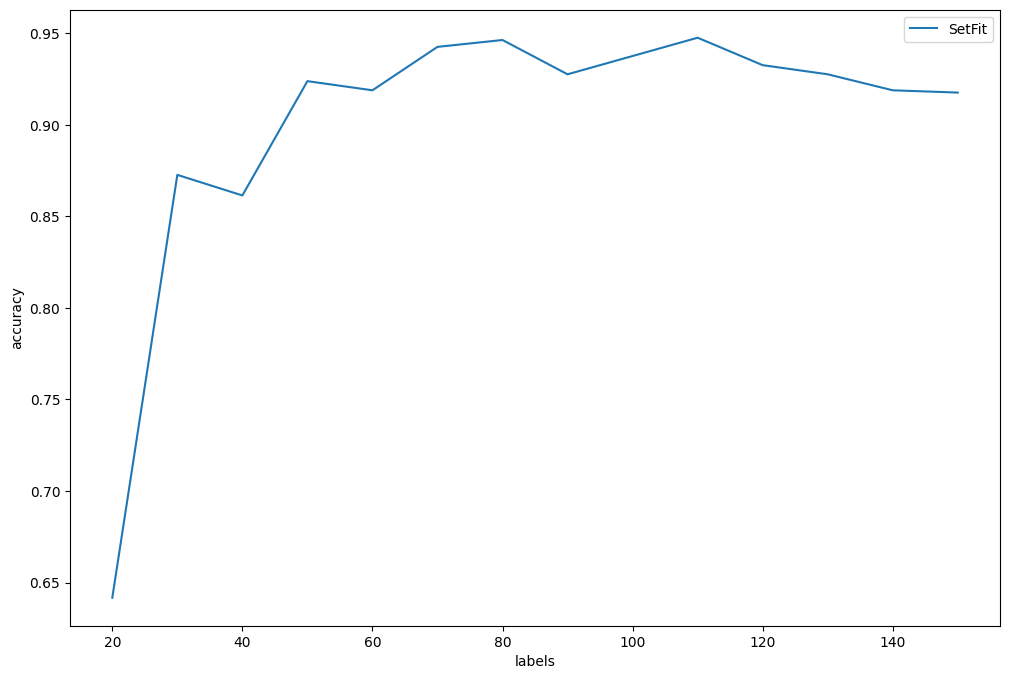

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.plot(label_list, accuracy_list, label='SetFit')
ax.legend()
plt.ylabel('accuracy')
plt.xlabel('labels')

display(plt)

In [18]:
from sklearn.metrics import confusion_matrix


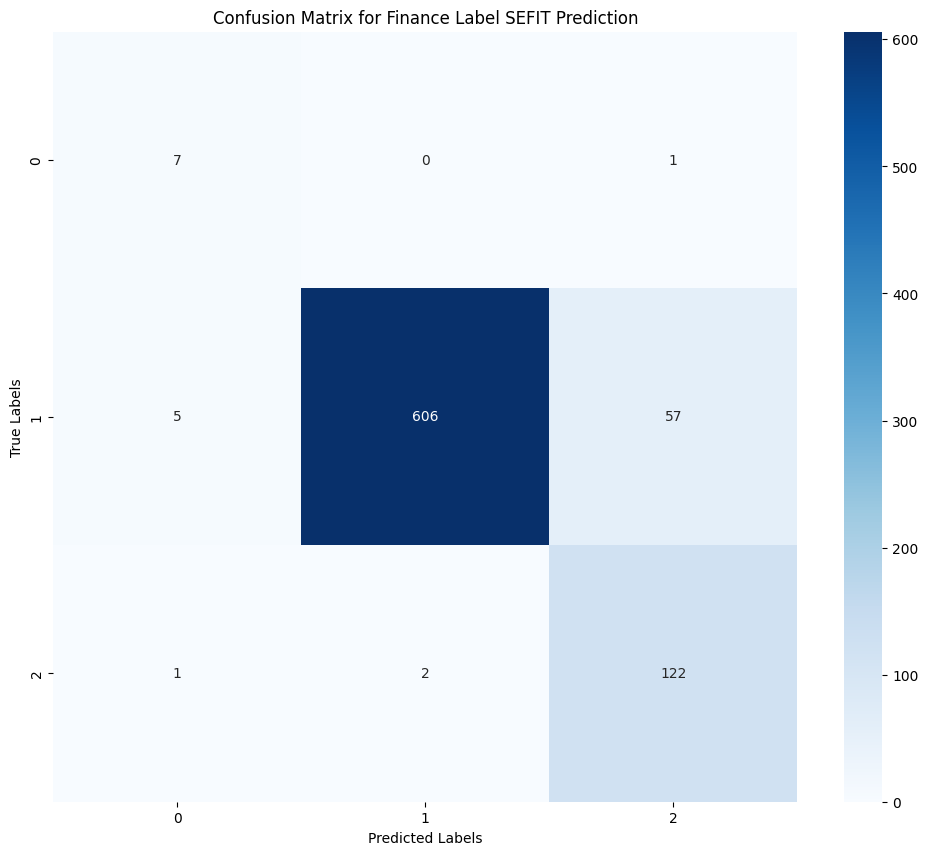

In [22]:
cm = confusion_matrix(dataset['train']['label'][499:1300],y_pred_test)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Finance Label SEFIT Prediction')
plt.show()

In [23]:
pd.DataFrame( {'actual': np.array(dataset['train']['sentence'][499:1300]),'y_pred_test' : y_pred_test} ).to_csv('Sefit_Predictions.csv',index=False)

In [24]:
setfit_label_acc_df = pd.DataFrame({'Label' : label_list  ,"Accuracy":accuracy_list, 'Precision' : precision_list, 'Recall': recall_list })

In [25]:
setfit_label_acc_df.to_csv('setfit_label_acc.csv', index=False)
